In [3]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Load and preprocess air traffic data
data = pd.read_csv('AirtrafficA4.csv', thousands=',')

month_map={
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUNE': 6,
    'JULY': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
data['MONTH']=data['MONTH'].str.strip()
data["#MONTH"]=data['MONTH'].map(month_map)
data = data.sort_values(by=['YEAR', '#MONTH']).reset_index(drop=True)

# Create a date index for time-series format
# data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'])
# data.set_index('DATE', inplace=True)
# data.info()
data

,AIRLINE,YEAR,MONTH,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE),#MONTH
0,A007,2013,JAN,10552.0,18655.0,10112.0,1408012.0,1820105.0,6465.0,0.0,1
1,A007,2013,FEB,9873.0,17374.0,9439.0,1341210.0,1698930.0,6235.0,0.0,2
2,A007,2013,MAR,11393.0,20093.0,11028.0,1423569.0,1984886.0,6505.0,0.0,3
3,A007,2013,APR,11426.0,20084.0,11090.0,1511094.0,1996084.0,5903.0,0.0,4
4,A007,2013,MAY,11885.0,20779.0,11533.0,1685168.0,2075882.0,7345.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...
123,A007,2023,APR,48752.0,84232.0,42615.0,7406440.0,8005648.0,19432.8,2102.9,4
124,A007,2023,MAY,50956.0,87917.0,44505.0,8109626.0,8375201.0,24165.1,2102.4,5
125,A007,2023,JUNE,49989.0,86217.0,43739.0,7893296.0,8254272.0,23522.6,2383.0,6
126,A007,2023,JULY,52127.0,90528.0,45404.0,7674890.0,8577184.0,24885.8,2585.0,7


In [1]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt 

def plot(y):
    # Augmented Dickey-Fuller test to test stationarity
    ADF_statistic, p_value = sm.tsa.stattools.adfuller(y)[0:2]
    print("ADF_statistic: ", ADF_statistic)
    print("P value: ", p_value)

    # Plotting ACF and PACF
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, ax=acf_ax)
    smt.graphics.plot_pacf(y, ax=pacf_ax)
    plt.tight_layout()

ADF_statistic:  -1.4398828551015794
P value:  0.563013574093058


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried')

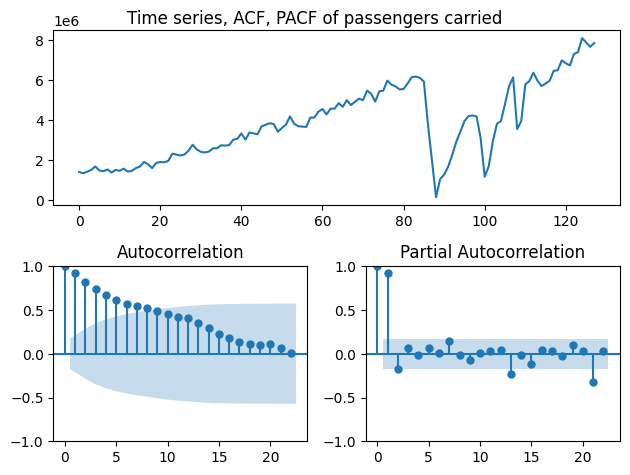

In [4]:
y=data['PASSENGERS CARRIED'].dropna()

plot(y)
plt.suptitle("Time series, ACF, PACF of passengers carried")

ADF_statistic:  -2.8225682299602193
P value:  0.055121668363918214


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried')

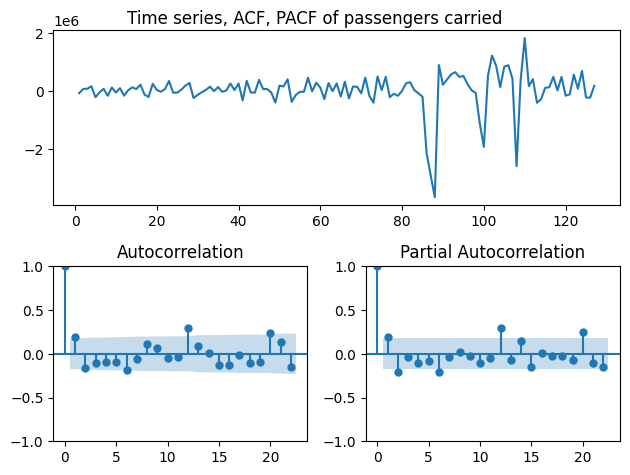

In [5]:
# Taking diff
y_diff=y.diff().dropna()
plot(y_diff)
plt.suptitle("Time series, ACF, PACF of passengers carried")

ADF_statistic:  -6.614124015638129
P value:  6.269337351334748e-09


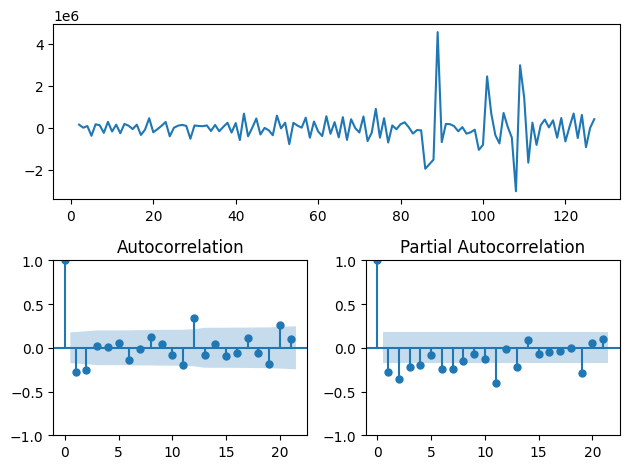

In [6]:
# Taking further difference
y_diff2=y_diff.diff().dropna()
plot(y_diff2)

ADF_statistic:  -8.614642742563282
P value:  6.338755472873354e-14


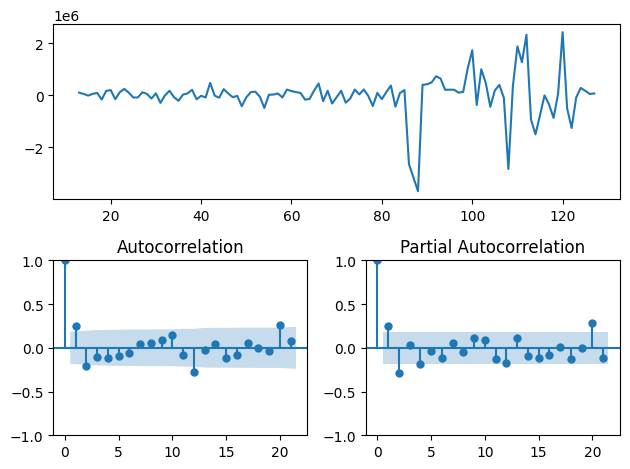

In [7]:
# Removing seasonality
y_shift=(y_diff-y_diff.shift(12)).dropna()
# Seasonality 6

plot(y_shift)

In [9]:
# Train-test split
train_size = int(0.6 * len(y)) # day_counts is only 127 data long T-T
train, test = y[:train_size], y[train_size:]

                                     SARIMAX Results                                     
Dep. Variable:                PASSENGERS CARRIED   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -942.964
Date:                           Mon, 28 Oct 2024   AIC                           1895.928
Time:                                   00:10:58   BIC                           1907.098
Sample:                                        0   HQIC                          1900.360
                                            - 76                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0845      0.515     -0.164      0.870      -1.093       0.924
ma.L1         -0.3205      0.499     -0.643

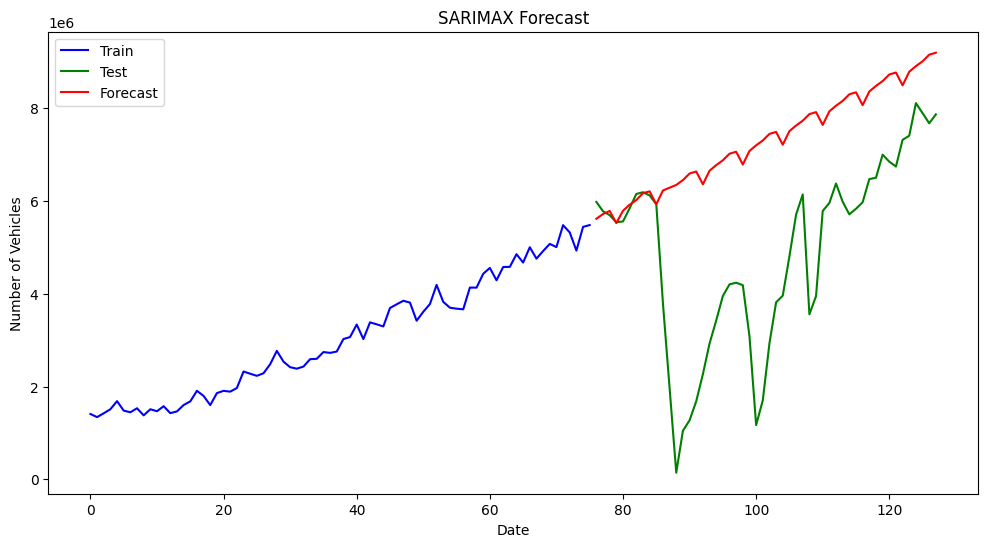

In [10]:
#Trying to fit a seasonal ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import (mean_absolute_scaled_error, mean_absolute_percentage_error)

# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))  # Adjust parameters as needed
model_fit = model.fit()

print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE
mase = mean_absolute_scaled_error(test, forecast, y_train=train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index  # Align forecast index
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 6)   Log Likelihood               -1013.733
Date:                                Mon, 28 Oct 2024   AIC                           2039.465
Time:                                        00:16:38   BIC                           2053.370
Sample:                                             0   HQIC                          2045.017
                                                 - 76                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    8.35e+04   4.63e+04      1.803      0.071   -7260.350    1.74e+05
ma.

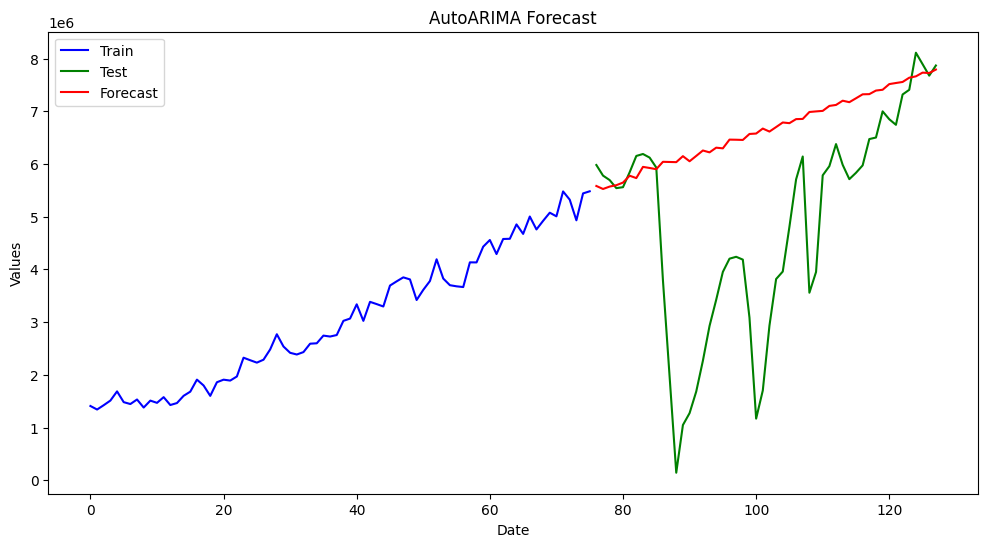

In [12]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(
    suppress_warnings=True,
    start_p=0,
    max_p=7,
    start_q=0,
    max_q=7,
    seasonal=True,
    sp=6
)

# Fit the model
forecaster.fit(train)

# Forecasting
fh = np.arange(1, len(test) + 1)  # Forecast horizon
forecast = forecaster.predict(fh=fh)


print(forecaster.summary())

# Calculate error metrics
mase = mean_absolute_scaled_error(test, forecast, y_train=train)
mape = mean_absolute_percentage_error(test, forecast)
print("MASE: ", mase, " MAPE: ", mape)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label="Train", color="b")
test.plot(label="Test", color="g")
forecast.index = test.index 
forecast.plot(label="Forecast", color="r")

plt.legend()
plt.title("AutoARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

In [107]:

y.loc[80:116] = np.nan

# Apply interpolation over the whole column (only affects NaNs)
y = y.interpolate(method='linear')


(127,)


C:\Users\jaine\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\jaine\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


predictions for next week
127    7.834953e+06
128    7.853667e+06
129    7.862795e+06
130    7.940409e+06
131    7.932448e+06
132    7.925608e+06
133    7.996171e+06
134    8.020705e+06
135    8.117173e+06
136    8.153420e+06
137    8.116804e+06
138    8.134330e+06
Name: predicted_mean, dtype: float64
   YEAR_MONTH  PASSENGERS CARRIED
0    2023 SEP        7.834953e+06
1    2023 OCT        7.853667e+06
2    2023 NOV        7.862795e+06
3    2023 DEC        7.940409e+06
4    2024 JAN        7.932448e+06
5    2024 FEB        7.925608e+06
6    2024 MAR        7.996171e+06
7    2024 APR        8.020705e+06
8    2024 MAY        8.117173e+06
9    2024 JUN        8.153420e+06
10   2024 JUL        8.116804e+06
11   2024 AUG        8.134330e+06


C:\Users\jaine\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jaine\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

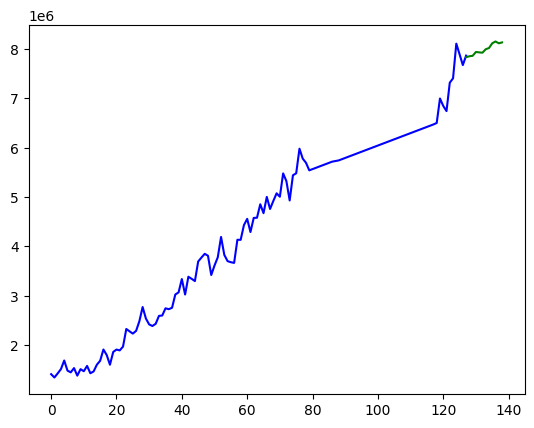

In [108]:
from sktime.forecasting.arima import AutoARIMA

# Fit the SARIMAX model
forecaster = SARIMAX(y, order=(0, 1, 1), seasonal_order=(1, 0, 2, 6))  # Adjust parameters as needed

pred=np.arange(128, 140)

# Fit the model
model_fit = forecaster.fit()
pred = model_fit.forecast(steps=len(pred))

print("predictions for next week")
print(pred)

months=['2023 SEP', '2023 OCT', '2023 NOV', '2023 DEC', '2024 JAN', '2024 FEB', '2024 MAR', '2024 APR', '2024 MAY', '2024 JUN', '2024 JUL', '2024 AUG']
submission=pd.DataFrame(list(zip(months, pred)), columns=['YEAR_MONTH', 'PASSENGERS CARRIED'])
submission.to_csv("submission.csv", index=False)

y.plot(label='total', color='b')
pred.plot(label='pred', color='g')
